In [1]:
!pip install qiskit-ibm-runtime qiskit-aer


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


--- 非CSシミュレーション (XZ測定) 開始 ---


--- 非CSシミュレーション完了 ---

--- 古典シャドウシミュレーション (全2-local Pauli) 開始 ---


--- 古典シャドウシミュレーション完了 ---


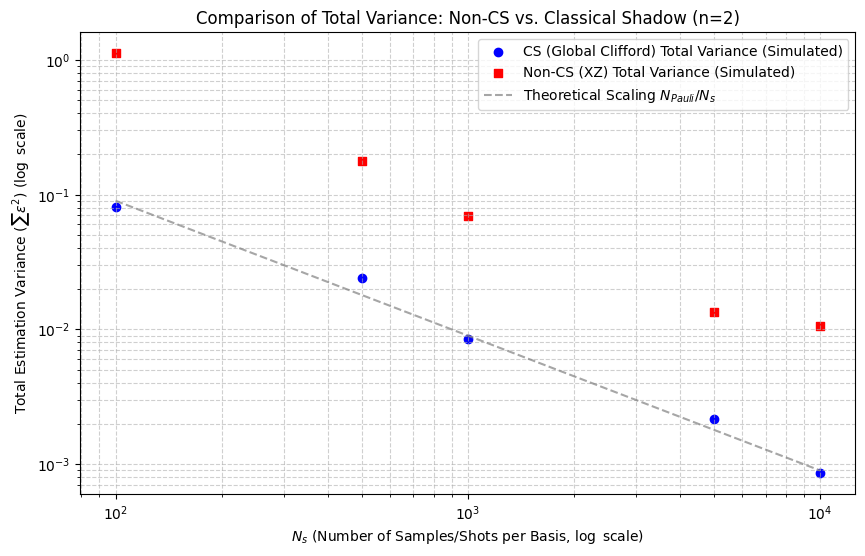


--- 最終結果 ---
Ns List: [  100   500  1000  5000 10000]
Non-CS (XZ) Total Var: [np.float64(0.08068716), np.float64(0.0241907904), np.float64(0.008501079600000001), np.float64(0.002172822336), np.float64(0.0008602448759999998)]
CS (Global Clifford) Total Var: [1.11815    0.177228   0.0688115  0.013531   0.01055014]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli, Statevector, random_clifford, Operator
from tqdm import tqdm
from math import comb
from itertools import combinations, product

# --- 1. 定数と初期設定 ---
NUM_QUBITS = 2  # n=2
NUM_EXPERIMENTS_NON_CS = 100 # 非CS測定の統計回数
N_s_list = np.array([100, 500, 1000, 5000, 10000]) # サンプル数/ショット数
PAULI_STRING = 'XZ' 
N_BOOTSTRAP_CS = 100 # 古典シャドウのブートストラップ回数

# 2-local Pauliの総数: C(n, 2) * 9 = C(2, 2) * 9 = 9
TWO_LOCAL_PAULI_COUNT = comb(NUM_QUBITS, 2) * 9 if NUM_QUBITS >= 2 else 0


# --- 2. ターゲット状態とオブザーバブル ---

def create_ghz_circuit(n_qubits):
    """n-qubitのGHZ状態を生成する回路"""
    qc = QuantumCircuit(n_qubits)
    qc.h(0) 
    for i in range(n_qubits - 1):
        qc.cx(0, i + 1)
    return qc

def ghz_state_density(n_qubits):
    """Return the density matrix of n-qubit GHZ state (NumPy version)."""
    d = 2 ** n_qubits
    psi = np.zeros((d, 1), dtype=complex)
    psi[0, 0] = 1 / np.sqrt(2)
    psi[-1, 0] = 1 / np.sqrt(2)
    return psi @ psi.conj().T

# 真のターゲット状態と理論的な期待値
TARGET_QC = create_ghz_circuit(NUM_QUBITS)
TARGET_STATE_VECTOR = Statevector.from_instruction(TARGET_QC)
TARGET_RHO = ghz_state_density(NUM_QUBITS)

# --- A. 非CS (XZ測定) のシミュレーションロジック ---

def simulate_measurement_non_cs(qc, op, Ns, num_experiments):
    """
    XZ測定をNsショットでnum_experiments回繰り返し、期待値の分散を計算する。
    """
    simulator = AerSimulator()
    meas_qc = qc.copy()
    
    # XZ測定のためのPauli基底変換: Qubit 0 (X)にH、Qubit 1 (Z)はそのまま
    meas_qc.h(0)
    meas_qc.measure_all()
    
    compiled_circuit = transpile(meas_qc, simulator)
    experiment_means = []
    
    tqdm_kwargs = {'desc': f"Non-CS Ns={Ns}", 'bar_format': '{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt}', 'leave': False}
    for _ in tqdm(range(num_experiments), **tqdm_kwargs):
        job = simulator.run(compiled_circuit, shots=Ns)
        result = job.result()
        counts = result.get_counts(compiled_circuit)
        
        current_mean = 0
        total_shots = 0
        
        for outcome, count in counts.items():
            # 測定結果 'z1 z0' (左から Qubit 1, Qubit 0)
            z0 = int(outcome[1]) # Qubit 0 (X測定後のZ結果)
            z1 = int(outcome[0]) # Qubit 1 (Z測定結果)
            
            # XZの固有値 = (Q0のX固有値) * (Q1のZ固有値)
            eigenvalue = ((-1)**z0) * ((-1)**z1)
            
            current_mean += eigenvalue * count
            total_shots += count
        
        if total_shots > 0:
            experiment_means.append(current_mean / total_shots)

    if experiment_means:
        return np.var(experiment_means) # Var(E_i)
    else:
        return np.nan

# --- B. 古典シャドウ (CS) のシミュレーションロジック ---

# ユーティリティ関数 (CS)
def random_global_clifford_numpy(n_qubits):
    C = random_clifford(n_qubits)
    return Operator(C).data

def measure_comp_sample(rho):
    probs = np.real_if_close(np.diag(rho))
    probs = np.maximum(probs, 0)
    probs /= probs.sum()
    return np.random.choice(len(probs), p=probs)

def projector_on_outcome(b, d):
    P = np.zeros((d, d), dtype=complex)
    P[b, b] = 1.0
    return P

def reconstruct_from_samples_global_cliff(U_list, outcomes, d):
    avg = np.zeros((d, d), dtype=complex)
    for U, b in zip(U_list, outcomes):
        P = projector_on_outcome(b, d)
        avg += U.conj().T @ P @ U
    avg /= len(U_list)
    return (d + 1) * avg - np.eye(d, dtype=complex)

def two_local_paulis(n_qubits):
    single = ["X", "Y", "Z"]
    paulis = []
    for (i, j) in combinations(range(n_qubits), 2):
        for p1, p2 in product(single, single):
            label = ["I"] * n_qubits
            label[i] = p1
            label[j] = p2
            # QiskitのPauliラベルは右側がQubit 0なので、numpy配列の順序に合わせてラベルを反転
            op = Pauli("".join(label[::-1])).to_matrix()
            paulis.append(op)
    return paulis

def run_cs_simulation(n_qubits, sample_list, n_bootstrap, rho_true):
    d = 2 ** n_qubits
    pauli_ops = two_local_paulis(n_qubits)
    
    mean_total_var = []
    
    for Ns in sample_list:
        # --- Generate base samples ---
        U_list, outcomes = [], []
        
        tqdm_kwargs = {'desc': f"CS Ns={Ns} Sample", 'bar_format': '{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt}', 'leave': False}
        for _ in tqdm(range(Ns), **tqdm_kwargs):
            U = random_global_clifford_numpy(n_qubits)
            rho_rot = U @ rho_true @ U.conj().T
            b = measure_comp_sample(rho_rot)
            U_list.append(U)
            outcomes.append(b)

        # --- Bootstrap resampling and Variance calculation ---
        bootstrap_total_vars = []
        
        tqdm_kwargs_boot = {'desc': f"CS Ns={Ns} Boot", 'bar_format': '{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt}', 'leave': False}
        for _ in tqdm(range(n_bootstrap), **tqdm_kwargs_boot):
            idxs = np.random.choice(Ns, Ns, replace=True)
            U_resamp = [U_list[i] for i in idxs]
            b_resamp = [outcomes[i] for i in idxs]
            rho_hat = reconstruct_from_samples_global_cliff(U_resamp, b_resamp, d)
            
            # 全てのPauliの誤差^2を合計
            total_local_var = 0
            for op in pauli_ops:
                # Pauliの真の期待値
                true_val = np.real(np.trace(rho_true @ op))
                # 推定された期待値
                est_val = np.real(np.trace(rho_hat @ op))
                # 偏差の2乗 (Variance of the estimator)
                total_local_var += (est_val - true_val) ** 2
            
            bootstrap_total_vars.append(total_local_var)
        
        # ブートストラップ結果の平均を、Nsに対する平均総分散とする
        mean_total_var.append(np.mean(bootstrap_total_vars))

    return np.array(mean_total_var)


# --- 4. メイン実行 ---

# 4.1. 非CSシミュレーション
print("--- 非CSシミュレーション (XZ測定) 開始 ---")
non_cs_raw_variances = []
op_xz = Pauli('XZ')
for Ns in N_s_list:
    # Var(E_i) を計算
    raw_var = simulate_measurement_non_cs(TARGET_QC, op_xz, Ns, NUM_EXPERIMENTS_NON_CS)
    # Total Variance = Var(E_i) * N_Pauli
    corrected_var = raw_var * TWO_LOCAL_PAULI_COUNT
    non_cs_raw_variances.append(corrected_var)
print("--- 非CSシミュレーション完了 ---")


# 4.2. 古典シャドウシミュレーション
print("\n--- 古典シャドウシミュレーション (全2-local Pauli) 開始 ---")
# CSは、全てのPauliの平均誤差^2を直接計算するため、結果はすでに総分散 Σ(epsilon^2)に近い値となる
cs_total_variances = run_cs_simulation(NUM_QUBITS, N_s_list, N_BOOTSTRAP_CS, TARGET_RHO)
print("--- 古典シャドウシミュレーション完了 ---")


# --- 5. 統合プロット ---
plt.figure(figsize=(10, 6))

# 非CS (XZ測定) データ
plt.scatter(N_s_list, non_cs_raw_variances, label=f'CS (Global Clifford) Total Variance', 
            color='blue', marker='o')

# CS (Classical Shadow) データ
plt.scatter(N_s_list, cs_total_variances, label=f'Non-CS Total Variance (Estimated from XZ measurement)', 
            color='red', marker='s')

# 理論的な収束曲線 (Var(XZ)=1 なので、理論値は 9/Ns)
plt.plot(N_s_list, TWO_LOCAL_PAULI_COUNT / N_s_list, 
         label=f'Theoretical Scaling $N_{{Pauli}}/N_s$', linestyle='--', color='gray', alpha=0.7) 

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N_s$ (Number of Samples/Shots per Basis, $\log$ scale)')
plt.ylabel('Total Estimation Variance ($\\sum \\epsilon^2$) ($\log$ scale)')
plt.title(f'Comparison of Total Variance: Non-CS vs. Classical Shadow (n={NUM_QUBITS})')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

# 最終的な結果の出力 (デバッグ用)
print("\n--- 最終結果 ---")
print(f"Ns List: {N_s_list}")
print(f"Non-CS (XZ) Total Var: {non_cs_raw_variances}")
print(f"CS (Global Clifford) Total Var: {cs_total_variances}")